### Regulations Mappings to Specific Agencies Using ECFR

In [1]:
import requests
import json

url = "https://www.ecfr.gov/api/admin/v1/agencies.json"
response = requests.get(url)
data = response.json()
#print(json.dumps(data, indent=2))

### Data Ingestion & Hierarchy Flattening of Top Level Agency JSON
> Consolidate agency JSON by extracting both top-level and child `cfr_references` while preserving parent-child relationships for comprehensive regulatory analysis

In [2]:
import pandas as pd

flattened_rows = []

for agency in data['agencies']:
    parent_name = agency.get('name')
    parent_short = agency.get('short_name')
    parent_slug = agency.get('slug')

    # Top-level CFR references
    for ref in agency.get('cfr_references', []):
        flattened_rows.append({
            'name': parent_name,
            'short_name': parent_short,
            'slug': parent_slug,
            'parent_name': None,
            'is_child': False,
            'agency_display_name': parent_name,
            'title': ref.get('title'),
            'subtitle': ref.get('subtitle'),
            'chapter': ref.get('chapter'),
            'subchapter': ref.get('subchapter'),
            'part': ref.get('part')
        })

    # Children CFR references
    for child in agency.get('children', []):
        for ref in child.get('cfr_references', []):
            flattened_rows.append({
                'name': child.get('name'),
                'short_name': child.get('short_name'),
                'slug': child.get('slug'),
                'parent_name': parent_name,
                'is_child': True,
                'agency_display_name': f"{child.get('name')} ({parent_name})",
                'title': ref.get('title'),
                'subtitle': ref.get('subtitle'),
                'chapter': ref.get('chapter'),
                'subchapter': ref.get('subchapter'),
                'part': ref.get('part')
            })

agencies_df = pd.DataFrame(flattened_rows)

# Preview the result
#print(agencies_df.head())
#print(f"Total CFR references across all agencies and children: {len(agencies_df)}")

### Add Grouping Column
> This column becomes the single source of truth for grouping and analysis

In [4]:
agencies_df['grouping_agency'] = agencies_df.apply(
    lambda row: row['parent_name'] if row['is_child'] else row['name'],
    axis=1
)
#print(agencies_df.head())
#agencies_df.head(25)


title_chapter_pairs = (
    agencies_df[['title', 'chapter']]
    .dropna()
    .drop_duplicates()
)
#title_chapter_pairs.head(25)

# Save data frame to a csv file
# agencies_df.to_csv("flattened_federal_agency_list.csv", index=False)
# print("Data frame saved to flattened_federal_agency_list.csv")

### Robust Data Downloading with Fallback Mechanism
> This function retrieves full title XML data from the eCFR API. If the full title is unavailable, it gracefully falls back to downloading individual chapter chunks—ensuring reliable data ingestion for further analysis.


In [5]:
import os

def download_title_or_chapters(title, date='2025-03-27', xml_dir='ecfr_titles', chapter_dir='ecfr_chapter_chunks'):
    title = str(title)
    title_url = f"https://www.ecfr.gov/api/versioner/v1/full/{date}/title-{title}.xml"
    save_path = os.path.join(xml_dir, date, f"title-{title}.xml")

    try:
        print(f"Trying title {title}...")
        response = requests.get(title_url, timeout=60)
        response.raise_for_status()
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        with open(save_path, 'wb') as f:
            f.write(response.content)
        print(f"Saved title {title} to {save_path}")
        return 'title'
    except:
        print(f"Failed title {title}, trying chapters...")

    chapters = (
        agencies_df[agencies_df['title'] == int(title)][['chapter']]
        .dropna()
        .drop_duplicates()['chapter']
    )
    for chapter in chapters:
        chapter_url = f"https://www.ecfr.gov/api/versioner/v1/full/{date}/title-{title}.xml?chapter={chapter}"
        chapter_path = os.path.join(chapter_dir, date, f"title-{title}", f"chapter-{chapter}.xml")
        try:
            r = requests.get(chapter_url, timeout=60)
            r.raise_for_status()
            os.makedirs(os.path.dirname(chapter_path), exist_ok=True)
            with open(chapter_path, 'wb') as f:
                f.write(r.content)
            print(f"Saved chapter {chapter} of title {title}")
        except:
            print(f"Failed chapter {chapter} of title {title}")
    return 'chapters'

In [6]:
def download_all_titles(date='2025-03-27'):
    titles = sorted(agencies_df['title'].dropna().unique())
    outcomes = {}
    for i, title in enumerate(titles):
        print(f"[{i+1}/{len(titles)}] Downloading Title {title}")
        outcome = download_title_or_chapters(title, date=date)
        outcomes[title] = outcome
    return pd.Series(outcomes)

### Robust Parsing & Fallback Retrieval of Regulation Text
> This function extracts regulation text by first attempting to load the complete title XML. If that fails, it gracefully falls back to loading specific chapter files. The function then navigates through optional subdivisions (subtitle, chapter, subchapter, part) to extract the relevant paragraphs, ensuring robust and precise data extraction


In [16]:
from bs4 import BeautifulSoup

def fetch_agency_text(title, chapter=None, subchapter=None, subtitle=None, part=None, 
                      date='2025-03-27', xml_dir='ecfr_titles', chapter_dir='ecfr_chapter_chunks'):
    """
    Retrieves eCFR regulation text for a given title by first attempting to load the complete XML file.
    If the full title XML is unavailable, it falls back to loading specific chapter XML files from the chapter directory.
    The function then navigates the XML hierarchy (using optional parameters: subtitle, chapter, subchapter, and part)
    to extract the relevant <P> tag content. This ensures robust and precise text extraction for further analysis.
    """
    local_path = os.path.join(xml_dir, date, f"title-{title}.xml")
    
    # Try loading the full title XML first.
    if os.path.exists(local_path):
        print(f"Loading full title XML from {local_path}")
        with open(local_path, 'r', encoding='utf-8') as f:
            soup = BeautifulSoup(f.read(), "xml")
    else:
        # Fallback: try loading from chapter files
        chapter_folder = os.path.join(chapter_dir, date, f"title-{title}")
        if os.path.exists(chapter_folder):
            # Only proceed if a specific chapter is provided.
            if chapter:
                chapter_file = os.path.join(chapter_folder, f"chapter-{chapter}.xml")
                if os.path.exists(chapter_file):
                    print(f"Full title XML not found. Loading specific chapter file: {chapter_file}")
                    with open(chapter_file, 'r', encoding='utf-8') as f:
                        soup = BeautifulSoup(f.read(), "xml")
                else:
                    print(f"Chapter file {chapter_file} not found in folder: {chapter_folder}. Skipping row.")
                    return None
            else:
                print(f"Full title XML not found and no specific chapter provided in folder: {chapter_folder}. Skipping row.")
                return None
        else:
            print(f"XML file not found in either {local_path} or chapter folder: {chapter_folder}")
            return None

    # Continue with the standard XML navigation when using a full title XML file or loaded chapter file.
    # Navigate the XML structure based on optional subdivisions.
    node = soup
    if subtitle:
        node = node.find("DIV2", {"TYPE": "SUBTITLE", "N": subtitle})
    if node and chapter:
        node = node.find("DIV3", {"TYPE": "CHAPTER", "N": chapter})
    if node and subchapter:
        node = node.find("DIV4", {"TYPE": "SUBCHAP", "N": subchapter})
    if node and part:
        node = node.find("DIV5", {"TYPE": "PART", "N": part})

    # If the expected node isn't found, report and return None.
    if not node:
        print(f"Could not locate path: Title={title}, Subtitle={subtitle}, Chapter={chapter}, Subchapter={subchapter}, Part={part}")
        return None

    paragraphs = node.find_all("P")
    if not paragraphs:
        print(f"No paragraphs found for structured path: Title {title}, Subtitle={subtitle}, Chapter={chapter}, Subchapter={subchapter}, Part={part}")
        fallback_part = soup.find("DIV5", {"TYPE": "PART"})
        if fallback_part:
            paragraphs = fallback_part.find_all("P")
            print(f"Fallback activated: Using first Part node found in Title {title}")
        else:
            print(f"No Part nodes available for fallback in Title {title}")
            return None

    paragraph_text = [p.get_text(separator=" ", strip=True) for p in paragraphs]
    return "\n".join(paragraph_text)

### Aggregating Regulatory Data & Debug Information
> Consolidate agency regulation data into a unified data frame — capturing key metrics like total word count, checksum, and CFR reference count (including children). Debug files are also saved for further inspection


In [59]:
import hashlib
from datetime import datetime

def build_results_df(agencies_df, date):
    results = [] 
    unique_agencies = agencies_df['grouping_agency'].unique()

    for i, agency in enumerate(unique_agencies):
        group = agencies_df[agencies_df['grouping_agency'] == agency]
        reference_count = len(group)   # count total CFR references (including children) for this agency

        print(f"\nProcessing agency {i+1}/{len(unique_agencies)}: {agency} (Date: {date})")
        print(f"→ Total CFR references: {reference_count} (including children)")
        print(f"   - From rows: {[name for name in group['name'].unique()]}")

        texts = []
        # Process each row (CFR reference) for this agency
        for _, row in group.iterrows():
            title      = row['title']          # required for API endpoint
            chapter    = row.get('chapter')    # optional
            part       = row.get('part')       # optional
            subtitle   = row.get('subtitle')   # optional
            subchapter = row.get('subchapter') # optional
        
            if pd.isnull(title):
                print("Skip if title is missing...")
                continue
        
            # Fetch regulation text content 
            text = fetch_agency_text(
                title=title, 
                chapter=chapter, 
                subtitle=subtitle, 
                subchapter=subchapter, 
                part=part,
                date=date)
            texts.append(text if text else "")
    
        # Combine the regulation text results from all rows for this agency
        combined_text = "\n\n".join(texts)

        # Save debug full regulation text to disk
        debug_dir = "regulation_debug_texts"
        os.makedirs(debug_dir, exist_ok=True)

        debug_df = pd.DataFrame({
            'grouping_agency': [agency],
            'date': [date],
            'combined_text': [combined_text]
        })
        slug = group.iloc[0]['slug']
        debug_filename = f"{slug}_{date}_debug_text.csv"
        debug_filepath = os.path.join(debug_dir, debug_filename)
        debug_df.to_csv(debug_filepath, index=False)
        print(f"Saved debug text for {agency} to {debug_filepath}")

        word_count = len(combined_text.split())
        print(f"→ Combined word count: {word_count:,}")
        
        # SHA-256 checksum
        checksum = hashlib.sha256(combined_text.encode("utf-8")).hexdigest() if combined_text else None
        print(f"→ Checksum: {checksum}")

        # Build a result entry with short_name and slug too
        agency_info = {
            'grouping_agency': agency,
            'short_name': group.iloc[0]['short_name'],
            'slug': group.iloc[0]['slug'],
            'word_count': word_count,
            'checksum': checksum,
            'reference_count': reference_count
            #'text_content': combined_text
        }
        results.append(agency_info)

    # Convert to data frame
    df = pd.DataFrame(results)

    return df

### Historical vs. Current Data Comparison
> Generate two snapshots of the eCFR data—one from 2020 (five years ago) and the current snapshot from March 27, 2025—to enable trend analysis and highlight regulatory changes over time

In [60]:
# Analyze data from 5 years ago
historical_df = build_results_df(agencies_df, date='2020-03-27')

# Most recent available eCFR snapshot date known to return valid data
current_df = build_results_df(agencies_df, date='2025-03-27')


Processing agency 1/153: Administrative Conference of the United States (Date: 2025-03-27)
→ Total CFR references: 1 (including children)
   - From rows: ['Administrative Conference of the United States']
Loading full title XML from ecfr_titles/2025-03-27/title-1.xml
Saved debug text for Administrative Conference of the United States to regulation_debug_texts/administrative-conference-of-the-united-states_2025-03-27_debug_text.csv
→ Combined word count: 12,042
→ Checksum: 8cde95db6515359af2f7e746b0b1b58244794ac9570ccfa200241c8f75b9a7d0

Processing agency 2/153: Advisory Council on Historic Preservation (Date: 2025-03-27)
→ Total CFR references: 1 (including children)
   - From rows: ['Advisory Council on Historic Preservation']
Loading full title XML from ecfr_titles/2025-03-27/title-36.xml
Saved debug text for Advisory Council on Historic Preservation to regulation_debug_texts/advisory-council-on-historic-preservation_2025-03-27_debug_text.csv
→ Combined word count: 30,003
→ Checksum

In [99]:
# historical_df.head(len(historical_df))

,grouping_agency,short_name,slug,word_count,checksum
0,Administrative Conference of the United States,ACUS,administrative-conference-of-the-united-states,12042,8cde95db6515359af2f7e746b0b1b58244794ac9570ccf...
1,Advisory Council on Historic Preservation,ACHP,advisory-council-on-historic-preservation,30003,5e673cae4d6493bdf89460fc48c037af7262d40e9365de...
2,Special Inspector General for Afghanistan Reco...,SIGAR,special-inspector-general-for-afghanistan-reco...,10493,cb6eb409387bc9a98e052857daa3dc91db185420dca005...
3,African Development Foundation,USADF,african-development-foundation,30001,ad1c89152031b7242bdb0548b17c3728898ffe842b41b6...
4,United States Agency for Global Media,USAGM,united-states-agency-for-global-media,77895,a7609c48641f59e9d6a073ef92936568f39b3f1525e5bf...
5,Department of Agriculture,USDA,agriculture-department,7316686,dc8dcc1e45bbf1bd9ca7ea8cccd4a6f83f3390019f984e...
6,Air Transportation System Stabilization,ATSB,air-transportation-stabilization-board,5989,cdb35ecdbe5bcb61240f5eabe26a013e36fdc6395e3cf3...
7,American Battle Monuments Commission,ABMC,american-battle-monuments-commission,10550,0105faef62f0acefba20ef515599c80cc96db4258d4f7c...
8,Appalachian Regional Commission,ARC,appalachian-regional-commission,41,2cc74d8bad7e017b6c894694368a097824249d85d749a0...
9,Architectural and Transportation Barriers Comp...,ATBCB,architectural-and-transportation-barriers-comp...,132926,283c19024284e290d3091e10c5fd05cfb3fbf1f5ee483f...


In [61]:
# current_df.head(len(current_df))

,grouping_agency,short_name,slug,word_count,checksum,reference_count
0,Administrative Conference of the United States,ACUS,administrative-conference-of-the-united-states,12042,8cde95db6515359af2f7e746b0b1b58244794ac9570ccf...,1
1,Advisory Council on Historic Preservation,ACHP,advisory-council-on-historic-preservation,30003,5e673cae4d6493bdf89460fc48c037af7262d40e9365de...,1
2,Special Inspector General for Afghanistan Reco...,SIGAR,special-inspector-general-for-afghanistan-reco...,10493,cb6eb409387bc9a98e052857daa3dc91db185420dca005...,1
3,African Development Foundation,USADF,african-development-foundation,30001,ad1c89152031b7242bdb0548b17c3728898ffe842b41b6...,2
4,United States Agency for Global Media,USAGM,united-states-agency-for-global-media,62156,66522527794d238421db5de054552f465e02bf445d58ee...,2
5,Department of Agriculture,USDA,agriculture-department,7880019,e094fe75d528d440d6a58e877b00702eb417a3f999de2c...,46
6,Air Transportation System Stabilization,ATSB,air-transportation-stabilization-board,5989,cdb35ecdbe5bcb61240f5eabe26a013e36fdc6395e3cf3...,1
7,American Battle Monuments Commission,ABMC,american-battle-monuments-commission,11720,4efd6ee8ca70a5bb2f0ea3c947e2c65415a2cbbdc39066...,1
8,Appalachian Regional Commission,ARC,appalachian-regional-commission,41,2cc74d8bad7e017b6c894694368a097824249d85d749a0...,1
9,Architectural and Transportation Barriers Comp...,ATBCB,architectural-and-transportation-barriers-comp...,148430,cc062996ceced0dc94f5635aec8966b85aa4c3194c0ad9...,1


In [102]:
# Save the updated data frames to CSV
historical_df.to_csv("historical_df.csv", index=False)
print("Data frame saved to historical_df.csv")

current_df.to_csv("current_df.csv", index=False)
print("Data frame saved to current_df.csv")


Data frame saved to historical_df.csv
Data frame saved to current_df.csv


### Total Regulation Word Count Analysis
> Compare the overall volume of regulation text from five years ago to the current snapshot. The sum of word counts for each period is computed to quantify the growth in regulatory content over time


In [75]:
total_word_count_historical = historical_df['word_count'].sum()
print("Total word count in 2020:", f"{total_word_count_historical:,}")

total_word_count_current = current_df['word_count'].sum()
print("Total word count in 2025:", f"{total_word_count_current:,}")

Total word count in 2020: 76,510,816
Total word count in 2025: 95,958,680


## Word Count Analysis 

### Top 20 Agency Leaderboard - Regulation Words
> This plot displays the top 20 agencies ranked by the total word count of their regulation texts (in millions). Each bar is annotated with its respective word count


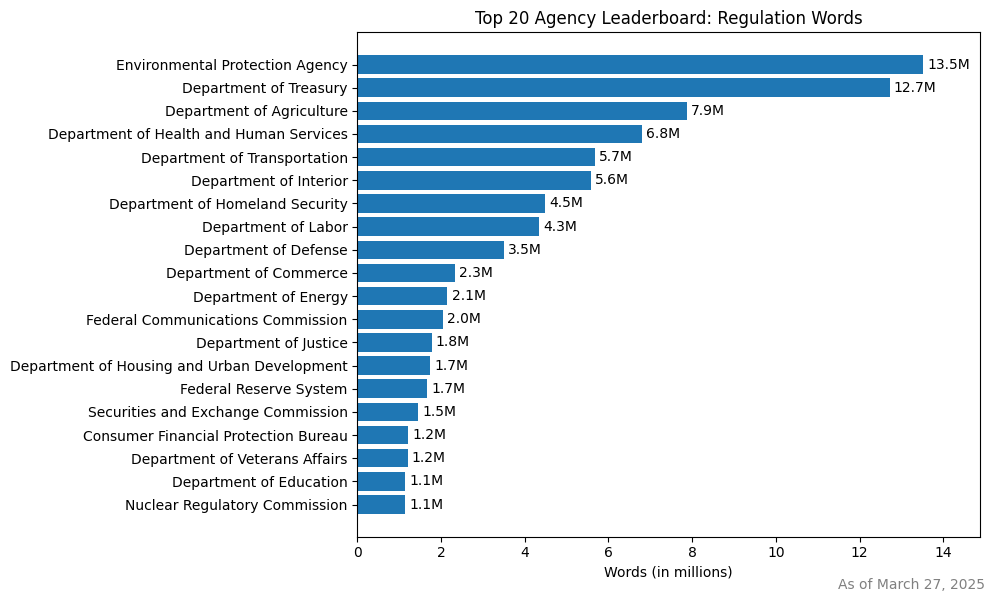

In [109]:
import matplotlib.pyplot as plt

# Leaderboard Top-20 agencies by word count
top20 = current_df.nlargest(20, 'word_count')

# Scale word counts to millions
word_counts_millions = top20['word_count'] / 1e6

plt.figure(figsize=(10, 6))
bars = plt.barh(top20['grouping_agency'], word_counts_millions)
plt.xlabel('Words (in millions)')
plt.title("Top 20 Agency Leaderboard: Regulation Words")
plt.gca().invert_yaxis()

# Extend x-axis limit dynamically with an extra 10% margin so the highest bar has space for annotation
plt.xlim(0, word_counts_millions.max() + 0.10 * word_counts_millions.max())

# Annotate each bar with its word count in the format "X.X M"
for bar in bars:
    width = bar.get_width()
    # Add annotation to the right of the bar, with a slight offset (0.1)
    plt.text(width + 0.1, bar.get_y() + bar.get_height() / 2, f"{width:.1f}M", 
             va='center', fontsize=10, color='black')

plt.figtext(0.99, 0.01, "As of March 27, 2025", horizontalalignment="right", fontsize=10, color="gray")
plt.tight_layout()
plt.show()

### All Agencies - Regulation Words

> This plot displays all agencies sorted by the total word count of their regulation texts. Each bar is annotated with its respective word count

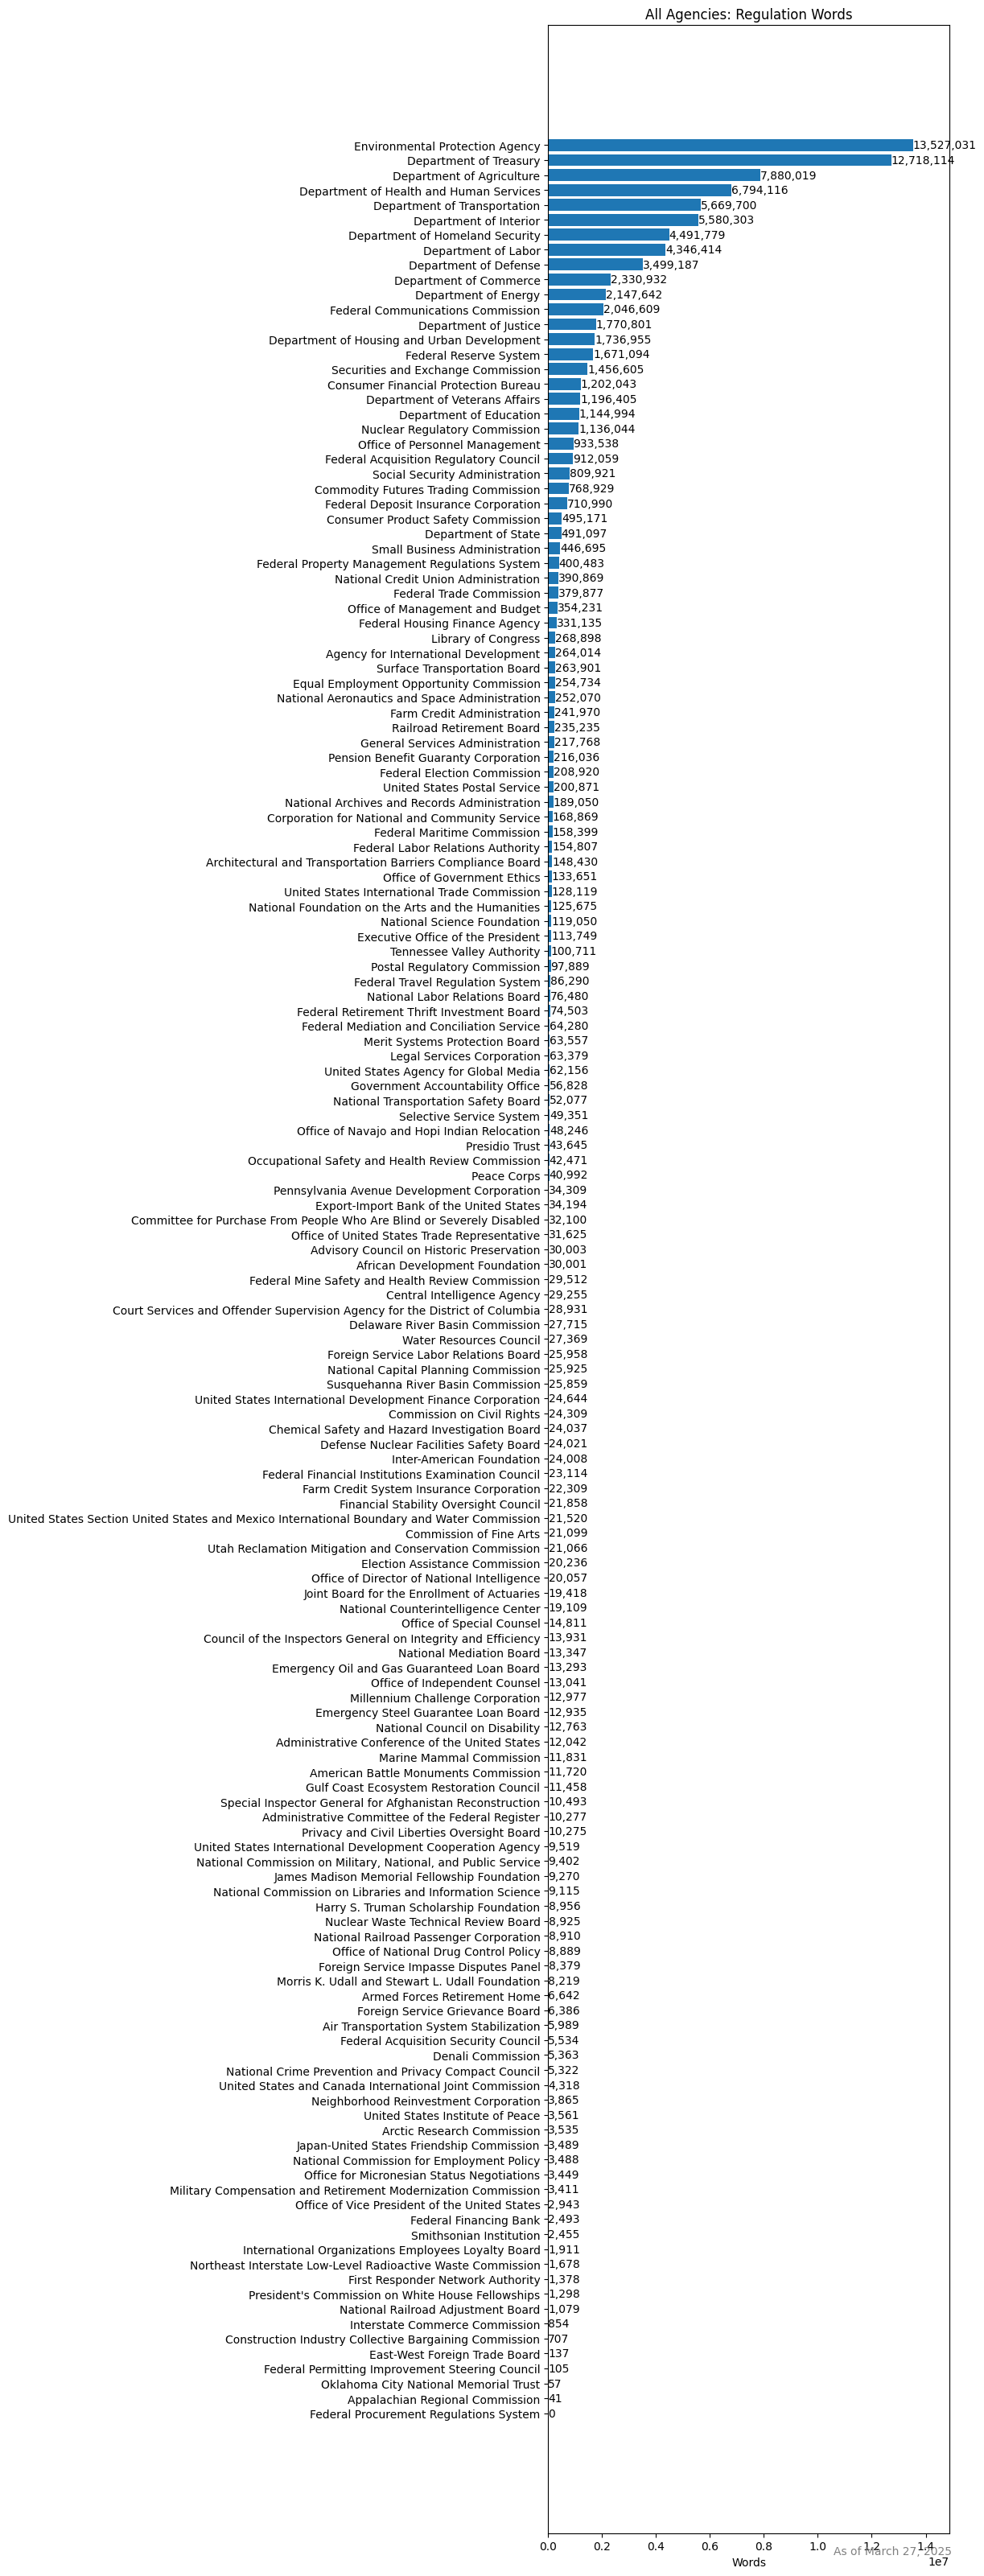

In [111]:
# Sort the data frame by word count in descending order for clarity
sorted_df = current_df.sort_values('word_count', ascending=False)

# Use raw word count values
word_counts_raw = sorted_df['word_count']

# Adjust figure size dynamically based on the number of agencies
plt.figure(figsize=(12, max(6, len(sorted_df) * 0.21)))  # Adjust height for clarity

# Create a horizontal bar plot
bars = plt.barh(sorted_df['grouping_agency'], word_counts_raw)
plt.xlabel('Words')
plt.title("All Agencies: Regulation Words")
plt.gca().invert_yaxis()  # Highest values at the top

# Extend x-axis limit dynamically with an extra 10% margin for annotation clarity
plt.xlim(0, word_counts_raw.max() + 0.10 * word_counts_raw.max())

# Annotate each bar with its raw word count (with commas)
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.1, bar.get_y() + bar.get_height() / 2, f"{width:,.0f}", 
             va='center', fontsize=10, color='black')

plt.figtext(0.99, 0.01, "As of March 27, 2025", horizontalalignment="right", fontsize=10, color="gray")
plt.tight_layout()
plt.show()



## Historical Change Analysis 
 
### Total Regulation Words: A 5-Year Comparison (2020 vs. 2025)
> This bar chart compares the total regulation text volume between 2020 and 2025, highlighting the substantial increase over the five-year period


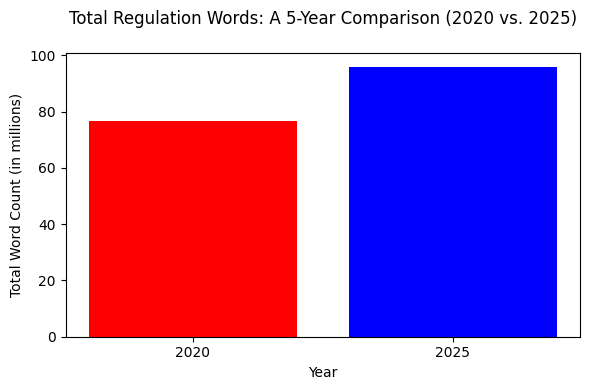

In [130]:
# Sample data - replace these with your actual computed values
total_word_count_millions_2020 = historical_df['word_count'].sum() / 1e6
total_word_count_millions_2025 = current_df['word_count'].sum() / 1e6

years = ['2020', '2025']
counts_millions = [total_word_count_millions_2020, total_word_count_millions_2025]
colors = ['red', 'blue']  # 2020 is red, 2025 is blue

plt.figure(figsize=(6, 4))
plt.bar(years, counts_millions, color=colors)

plt.xlabel("Year")
plt.ylabel("Total Word Count (in millions)")

title = ("Total Regulation Words: A 5-Year Comparison (2020 vs. 2025)\n")
plt.title(title, fontsize=12)

plt.tight_layout()
plt.show()

## Checksum Analysis

### Tracking Regulatory Changes 

> This code merges the historical (2020) and current (2025) datasets by agency and compares their checksums to identify changes in regulation text. It then counts and outputs how many of the 153 agencies have experienced modifications

In [101]:
# Merge the current and historical data frames on the agency identifier
merged_df = pd.merge(
    current_df[['grouping_agency', 'checksum']],
    historical_df[['grouping_agency', 'checksum']],
    on='grouping_agency',
    suffixes=('_current', '_historical')
)

# Determine which agencies have a changed checksum
merged_df['changed'] = merged_df['checksum_current'] != merged_df['checksum_historical']

# Count the number of agencies with changed regulation text
num_changed = merged_df['changed'].sum()
total_agencies = len(merged_df)
print(f"Number of agencies with regulation text changes: {num_changed} out of {total_agencies}")


Number of agencies with regulation text changes: 99 out of 153


## Custom Metrics Analysis 
 
### Regulatory Density Score Calculation
> This cell calculates the average word count per CFR reference using the current dataset. The resulting score (referred to as the Regulatory Density Score) provides insight into the average verbosity of the regulations. A higher score indicates that, on average, each CFR reference contains more text, which may signal opportunities to simplify overly complex regulatory language.


In [83]:
reg_density = current_df['word_count'].mean()
print(f"Regulatory Density Score in 2025: {reg_density:.1f} words per CFR reference")

Regulatory Density Score in 2025: 627180.9 words per CFR reference


### Top 20 Agency Leaderboard - Regulatory Density Score

> This section computes the average word count per CFR reference for each agency, selects the top 20, and plots them

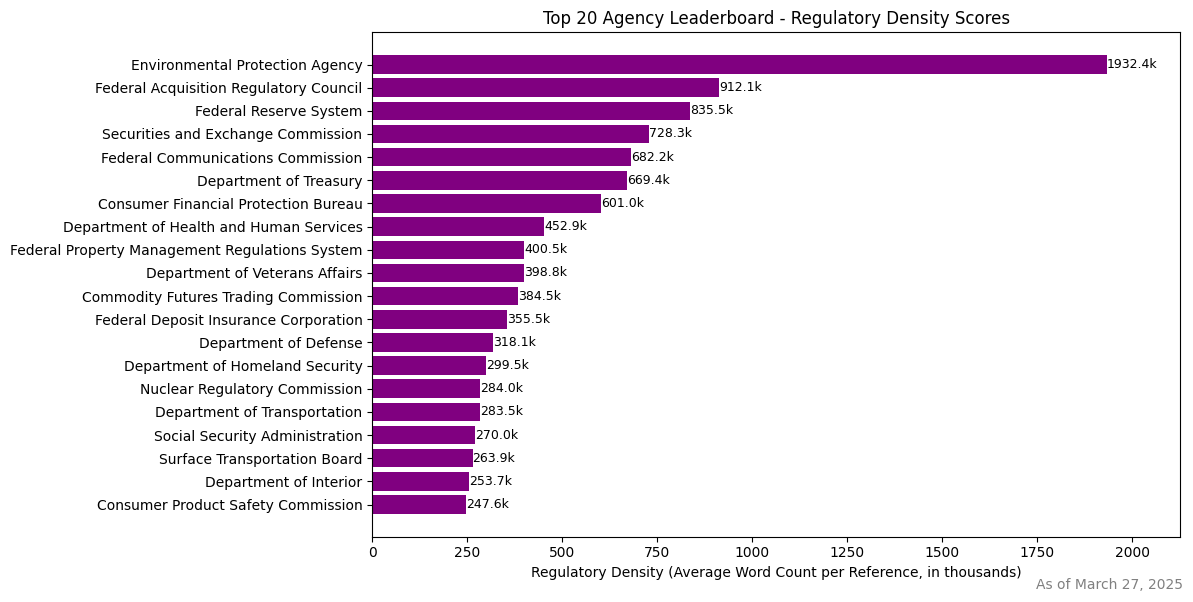

In [115]:
# Compute the Regulatory Density Score per agency:
current_df['reg_density'] = current_df['word_count'] / current_df['reference_count']

# Leaderboard Top-20 agencies by density score
top20 = current_df.nlargest(20, 'reg_density')

# Scale the density for visualization (in thousands of words)
top20['reg_density_k'] = top20['reg_density'] / 1e3
max_density = top20['reg_density_k'].max()

# Create a horizontal bar plot with dynamic figure height for clarity
plt.figure(figsize=(12, max(6, len(top20) * 0.21)))
bars = plt.barh(top20['grouping_agency'], top20['reg_density_k'], color='purple')
plt.xlabel('Regulatory Density (Average Word Count per Reference, in thousands)')
plt.title('Top 20 Agency Leaderboard - Regulatory Density Scores')
plt.gca().invert_yaxis()  # Highest density at the top

# Extend x-axis limit dynamically with an extra 10% margin
plt.xlim(0, max_density + 0.10 * max_density)

# Annotate each bar with the density value in thousands (formatted as "X.Xk")
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.1, bar.get_y() + bar.get_height() / 2,
             f"{width:.1f}k", va='center', fontsize=9)

plt.figtext(0.99, 0.01, "As of March 27, 2025", horizontalalignment="right", fontsize=10, color="gray")
plt.tight_layout()
plt.show()

### Density & Distribution Analysis of Regulation Sizes
> This cell visualizes agency regulation sizes (in millions of words) using both a kernel density plot and a histogram with KDE


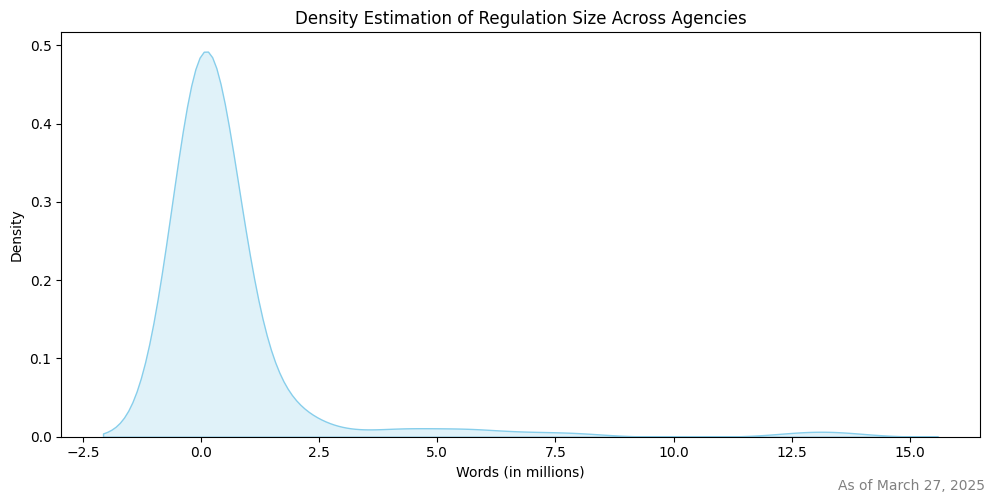

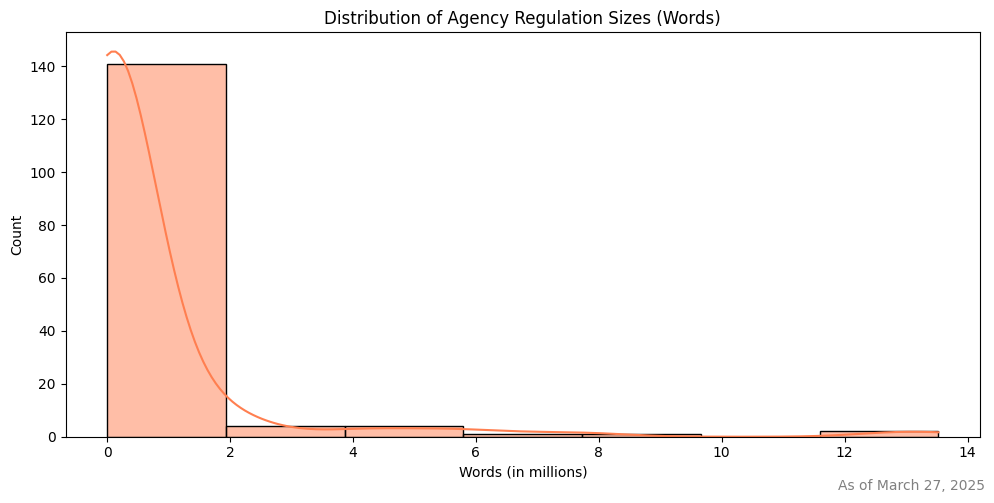

In [129]:
import seaborn as sns

# Make sure word counts are in millions
word_counts_millions = current_df['word_count'] / 1e6

plt.figure(figsize=(10, 5))
sns.kdeplot(word_counts_millions, fill=True, color='skyblue')
plt.xlabel("Words (in millions)")
plt.title("Density Estimation of Regulation Size Across Agencies")
plt.figtext(0.99, 0.01, "As of March 27, 2025", horizontalalignment="right", fontsize=10, color="gray")
plt.tight_layout()
plt.show()

# Kernel Density Estimation
plt.figure(figsize=(10, 5))
sns.histplot(word_counts_millions, bins=7, kde=True, color='coral')
plt.xlabel("Words (in millions)")
plt.title("Distribution of Agency Regulation Sizes (Words)")
plt.figtext(0.99, 0.01, "As of March 27, 2025", horizontalalignment="right", fontsize=10, color="gray")
plt.tight_layout()
plt.show()